In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from multinomial_kernel import MultinomialLogisticRegression
from preprocess import Preprocess
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
raw_train_data = "../../data/train.csv"
raw_test_data = "../../data/test.csv"

In [3]:
preproc = Preprocess()
raw_data = preproc.load_data(raw_train_data)

raw_data[raw_data.columns[~raw_data.columns.isin(["time", "SNo"])]].columns
raw_data_count = raw_data.groupby(['lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS',
       'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT']).Label.nunique().reset_index(name="Label_count")
raw_data_count = pd.merge(raw_data, raw_data_count, how='left', on=['lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS',
       'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT'])

In [6]:
raw_data_count = raw_data_count[~(
    (raw_data_count["Label"].isin([1])) & (raw_data_count["Label_count"] == 3)
    )]

In [7]:
raw_data_count = raw_data_count.drop("SNo", axis=1).drop_duplicates(keep="first")

In [8]:
cols = ['lat', 'TS', 'TMQ', 'U850', 'PS', 'Z1000', 'PSL', 'Z200', 'lon', 'UBOT', 'T500',
        "Label"]

train_df, train_data = preproc.preprocess_data(raw_data, drop_cols=["SNo", "time"])
train_df = train_df[cols]

np.random.shuffle(train_data)
X_train, y_train, X_valid, y_valid = preproc.train_valid_split(
    train_df.to_numpy(), test_size=0.33 #, random_state=42
)

print(train_df.columns)

X_train = preproc.normalize_data(X_train)
X_valid = preproc.normalize_data(X_valid)

train_df_norm = preproc.normalize_data(train_df.to_numpy())

Index(['lat', 'TS', 'TMQ', 'U850', 'PS', 'Z1000', 'PSL', 'Z200', 'lon', 'UBOT',
       'T500', 'Label'],
      dtype='object')


# Wrapper method

In [10]:
model = MultinomialLogisticRegression(learning_rate=0.1, num_iterations=1000, regularizer=0.01)
model.fit(X_train, y_train, collist=raw_data.columns, valid_x=X_valid, valid_y=y_valid)

# Make predictions.
predictions = model.predict(X_valid)
print(train_df.columns)

model.get_metrics(y_valid, predictions, return_values=False)

Epoch 0, cross entropy loss: 1.0986122886681096
Epoch 100, cross entropy loss: 0.7351263558850039
Epoch 200, cross entropy loss: 0.6886336795186007
Epoch 300, cross entropy loss: 0.6733528922188606
Epoch 400, cross entropy loss: 0.6655558201934962
Epoch 500, cross entropy loss: 0.6605410418355144
Epoch 600, cross entropy loss: 0.656880299413959
Epoch 700, cross entropy loss: 0.6540069853220013
Epoch 800, cross entropy loss: 0.6516503357928456
Epoch 900, cross entropy loss: 0.64966211330778
Index(['lat', 'TS', 'TMQ', 'U850', 'PS', 'Z1000', 'PSL', 'Z200', 'lon', 'UBOT',
       'T500', 'Label'],
      dtype='object')
Confusion Matrix:
[[10400   191  1038]
 [  344   229     5]
 [ 1164    15  1385]] 

Accuracy:
0.8134 

Precision:
0.6567 

Recall:
0.6102 

F1 Score:
0.6326


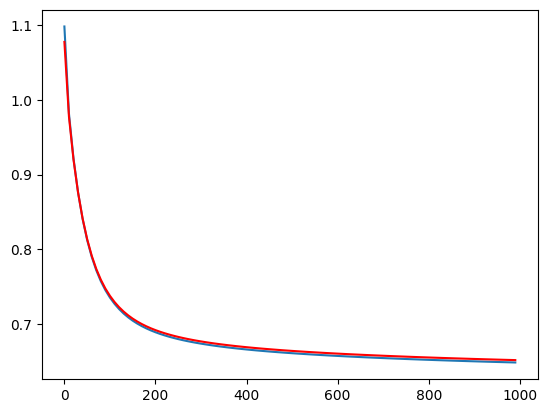

In [12]:
plt.plot(
    model.iters,
    model.train_errors
)

plt.plot(
    model.iters,
    model.valid_errors,
    color='r'
)

predictions_2023-10-25 23:37:22.889423_opt_multinomial_rm_dupls -> todas as colunas + reg = 0.01

acc = 0.735

predictions_2023-10-25 23:37:22.889423_opt_multinomial_rm_dupls_top_cols -> 'lat', 'TS', 'TMQ', 'U850', 'PS', 'Z1000', 'PSL', 'Z200', 'lon', 'UBOT' (top 50% cols) + reg = 0.1

acc = 0.755

predictions_2023-10-25 23:37:22.889423_opt_multinomial_rm_dupls_top_cols -> 'lat', 'TS', 'TMQ', 'U850', 'PS', 'Z1000', 'PSL', 'Z200', 'lon', 'UBOT', 'T500', (top 50% cols) + reg = 0.1 + count < 3

acc = 

predictions_2023-11-03 21:00:45.548655_rm_dupls_top_cols_rmdups_1_2 removendo duplicados do 1 e do 2

acc = 0.753

predictions_2023-11-03 21:00:45.548655_rm_dupls_top_cols_rmdups_1_2

acc 0.769

---

In [13]:
preproc = Preprocess()
raw_data = preproc.load_data(raw_test_data)

test_df, test_data = preproc.preprocess_data(raw_data, drop_cols=["SNo", "time"], is_test=True)

test_data = test_df[['lat', 'TS', 'TMQ', 'U850', 'PS', 'Z1000', 'PSL', 'Z200', 'lon', 'UBOT', 'T500']].to_numpy()

test_data = preproc.normalize_data(test_data)

In [14]:
test_data.shape

(10320, 11)

In [63]:
y_pred_test = model.predict(X=test_data)

In [64]:
submition = raw_data['SNo'].reset_index().copy()
submition['Label'] = pd.Series(y_pred_test)
submition.drop("index", axis=1, inplace=True)
submition.to_csv(f"predictions_{datetime.now()}_rm_dupls_top_cols_rmdups_1_2_dropdupls.csv", index=False)